#Costa Rican household Poverty Level Prediction

The object of the Costa Rican househld Poverty Level prediction contest is to develop a ML model that can predict the poverty level of households using both individual and household characteristics. This 'data science for good' project offers the opportunity to put our skills towards a task more beneficial to society than getting people to click on ads!

In this notebook, we will wak through a complete machine learning solution :

First, get intoduced to the problem, then perform a thorough Exploratory Data Analysis of the dataset, work on feature engineering, try out multiple machine learning models, select a model, work to optimize the model, and finally, inspect the outputs of the model and draw conclusions.

while this notebook may not get us to the top of the leaderboard, it is meant to be used as a teaching tool to give you a solid foundation to build on for future machine learning projects.

Kaggle projects can teach us a lot about machine learning, but several of the strategies used to get to the very top of the leaderboard are not bestpractices, so here wi'll stick to building a very good - although not quite first place - machine learning solution. While Kaggle projects a re competitions, I think they are best described as 'a machine learning education' disguised as a contest



##Problem and Data Explanation

The data for this competition is provided in two files : train.csv and test.csv. The training set ha s 9557 rows and 143 columns while the testing set has 23856 rows and 142 columns. Each row represents one individual and each columns is a feature,either unique to the individual, or for the household of the individual. The training set has one additional column, target, which represents the ***poverty level on a 1-4*** scale and is the label for the competetion. A value of 1 i s the most extream poverty.

This is a supervised-multi-class classification machine learning problem :
- supervised : provided with the lael for the training data
- Multi-class classification : Labels are discrete values with 4 classes



###Objective

The objective is to predict poverty on a household level. We are given data on the individual level with each individual having unique features but also information about their household. In order to create a dataset for the task, we'll have to perform some ***aggregations of the individual data*** for each household. Moreover, we have to make a prediction for every individual in the test set, but 'only the heads of household are used in scoring' which means we want to predict poverty on a household basis.


note : while all members of a household should habe the same label in the training data, there are errors where individuals in the same household habe different labels. In these cases, we a re hold to use the label for the head of each household, which can be identified by the rows where **parentesco1 == 1.0** . We will cover how to correct this in the notebook.



###Core Data fields
- Id - a unique identifier for each row.
- Target - the target is an ordinal variable indicating groups of income levels.
1. = extreme poverty
2. = moderate poverty
3. = vulnerable households
4. = non vulnerable households
 
- idhogar - this is a unique identifier for each household. This can be used to create household-wide features, etc. All rows in a given household will have a matching value for this identifier.
- parentesco1 - indicates if this person is the head of the household.

This data contains 142 total columns.

####Meric

Ultimately we want to build a machine learning model that can predict the integer poverty level of a household. Out predictions will be assessed by the **Marco F1 Score**. you may be familiar with the standard f1 score for binary classification problems which is the harmonic mean of precision and recall :

F1=2* (precision * recall)/(precision + recall)

For multi-class problems, we have to avg the F1 score for each class. so, Marco F1 is :

(F1 Cls 1 + F1 Cls 2 + F1 Cls 3 + F1 Cls 4) /4

In other words, the number of occurrences of each label does not figure into the calculation when using macro. we can use the code :

(

from sklearn.metrics import f1_score

f1_score(y_true, y_redicted, average = 'macro')

)

For this problem, the laels are imbalanced, which makes it a little strange to use macro averaging for the evaluation metric, but that's a decision made by the organizers and not something we can change.

###Roadmap

The end objective is a machine learning model that can predict the poverty level of a household However, before we get carried away with modeling, it's important to understand the problem and data. Also, we wnat to evaluate numerous models before choosing one as the 'best' and after building a model, we want to investigate the prodictins. Out roadmap is therefore as follows :

1. Understand the problem
2. EDA
3. Feature engineering to create a dataset for machine learning
4. Compare several baseline machine learning models
5. Try more complex machine learning models
6. Optimize the selected model
7. Investigate model predictions in context of problem
8. Draw conclusions and lay out next steps

#Getting Started

we have a pretty good grasp of the problem, so we'll move into the EDA and feature engineering. For the EDA we'll examine any interesting anomalies, trends, correlations, or patterns that can be used for feature engineering and for modeling. We'll make sure to investigate our data both quatitatively and visually.

Once we have a good graps of the data and any potentially useful relationships, we cna so some feature engineering and establish a baseline model. This won't get us to the top of the leaderboard, but it will provide a strong foundation to build on.

In [ ]:
import pandas as pd
import numpy as np

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

#set a few plotting defaults
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size']=18
plt.rcParams['patch.edgecolor']= 'k'

Read in Data and look at summary information

In [ ]:
# pd.options.display.max_columns = 150

# #read in data
# train = pd.read_csv('../input/train.csv')
# test  = pd.read_csv('../input/test.csv')
# train.head()

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

direc='/content/drive/MyDrive/주피터_대피소/kaggle&github/Kaggle/4.Costa_Rican_Household_Poverty/'
train=pd.read_csv(direc+'train.csv')
test=pd.read_csv(direc+'test.csv')
train.head()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Columns: 142 entries, Id to agesq
dtypes: float64(8), int64(129), object(5)
memory usage: 25.8+ MB


Text(0.5, 1.0, 'count of unique values in integer columns')

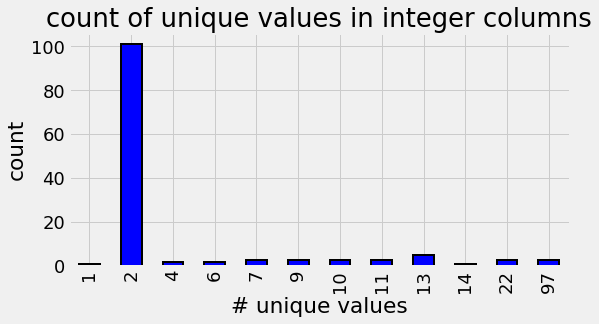

In [ ]:
train.select_dtypes(np.int64).nunique().value_counts().sort_index().plot.bar(color = 'blue', 
                                                                            figsize=(8,4),
                                                                            edgecolor='k',
                                                                            linewidth=2)
plt.xlabel('# unique values')
plt.ylabel('count')
plt.title('count of unique values in integer columns')

Float columns

Anohter column type is floats which represent continuous variables. we can make a quick distribution plot to show the distribution of all float columns. well use an **orderedDict**  to map the poverty levels to colos because this keeps the keys and values in the same order as w especify

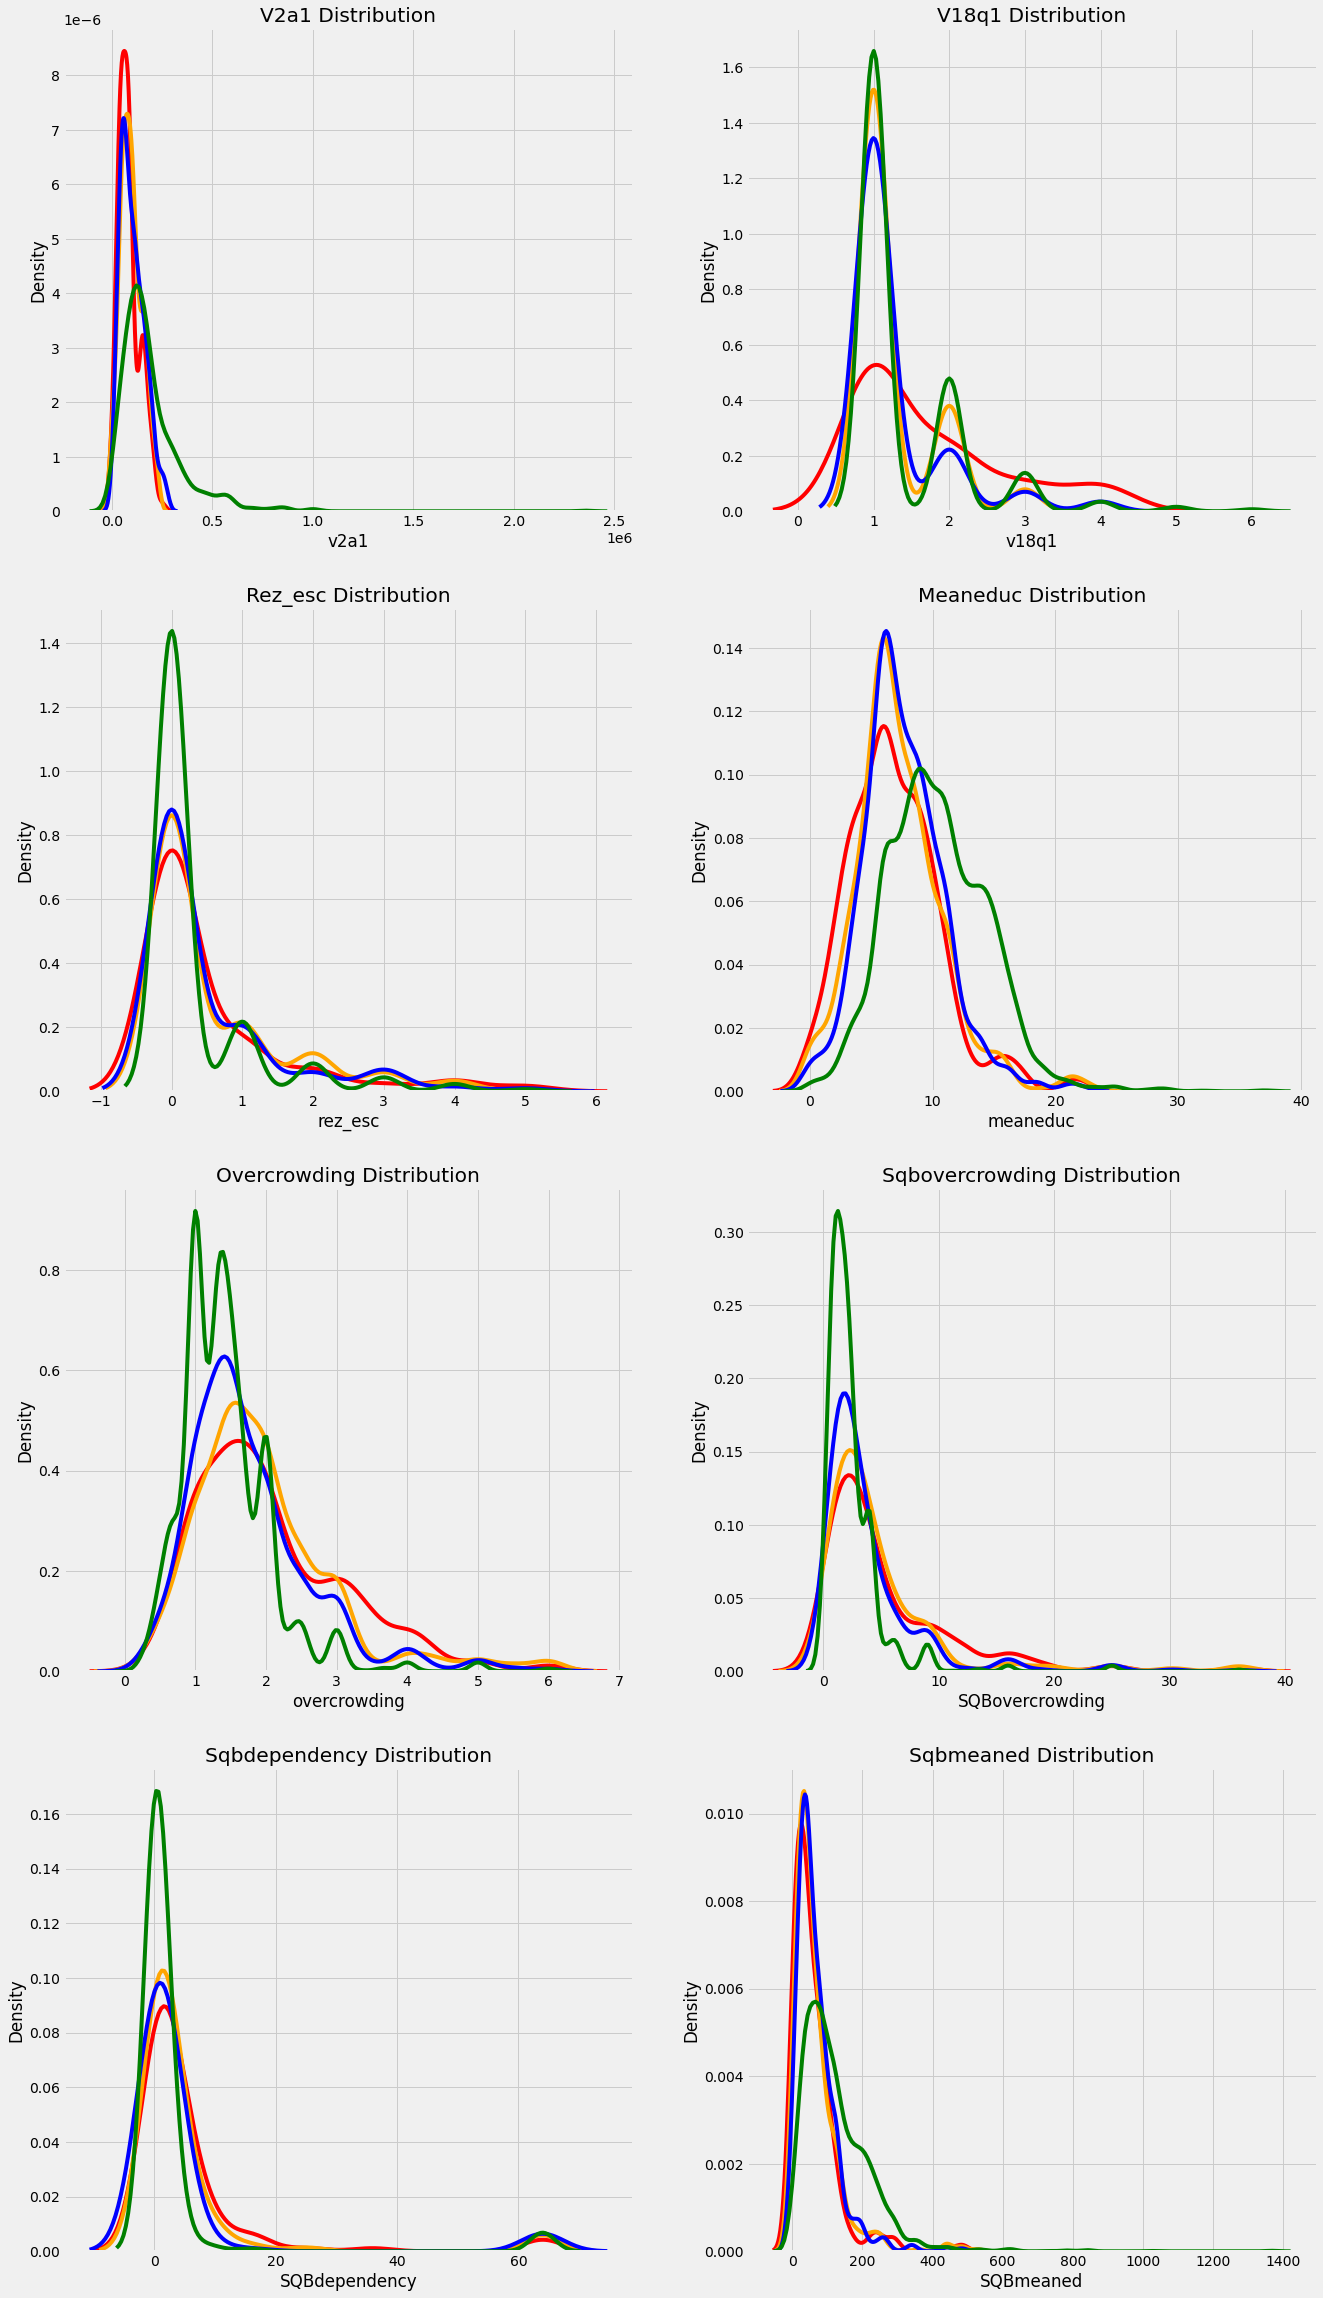

In [ ]:
from collections import OrderedDict

plt.figure(figsize=(20,16))
plt.style.use('fivethirtyeight')

#color mapping
colors = OrderedDict({1 :'red', 2:'orange', 3:'blue',4:'green'})

poverty_mapping = OrderedDict({1 : 'extread',2:'moderate',3:'vulnerable',4:'non vulnerable'})

for i, col in enumerate(train.select_dtypes('float')) :
  ax=plt.subplot(4,2,i+1)

  for poverty_level, color in colors.items() :
    sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(), ax =ax, color=color, label = poverty_mapping[poverty_level])

  plt.title(f'{col.capitalize()} Distribution')
  plt.xlabel(f'{col}')
  plt.ylabel('Density')

plt.subplots_adjust(top=2)


In [ ]:
train.select_dtypes('object').head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


- dependency: Dependency rate, calculated = (number of members of the household younger than 19 or older than 64)/(number of member of household between 19 and 64)
- edjefe: years of education of male head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0
- edjefa: years of education of female head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0

In [ ]:
mapping = {'yes' : 1, 'no' : 0}

for df in [train,test] :
  df['dependency'] = df['dependency'].replace(mapping).astype(np.float64)
  df['edjefa'] = df['edjefa'].replace(mapping).astype(np.float64)
  df['edjefe'] = df['edjefe'].replace(mapping).astype(np.float64)

train[['dependency','edjefa','edjefe']].describe()


,dependency,edjefa,edjefe
count,9557.000000,9557.000000,9557.000000
mean,1.149550,2.896830,5.096788
std,1.605993,4.612056,5.246513
min,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000
50%,0.666667,0.000000,6.000000
75%,1.333333,6.000000,9.000000
max,8.000000,21.000000,21.000000


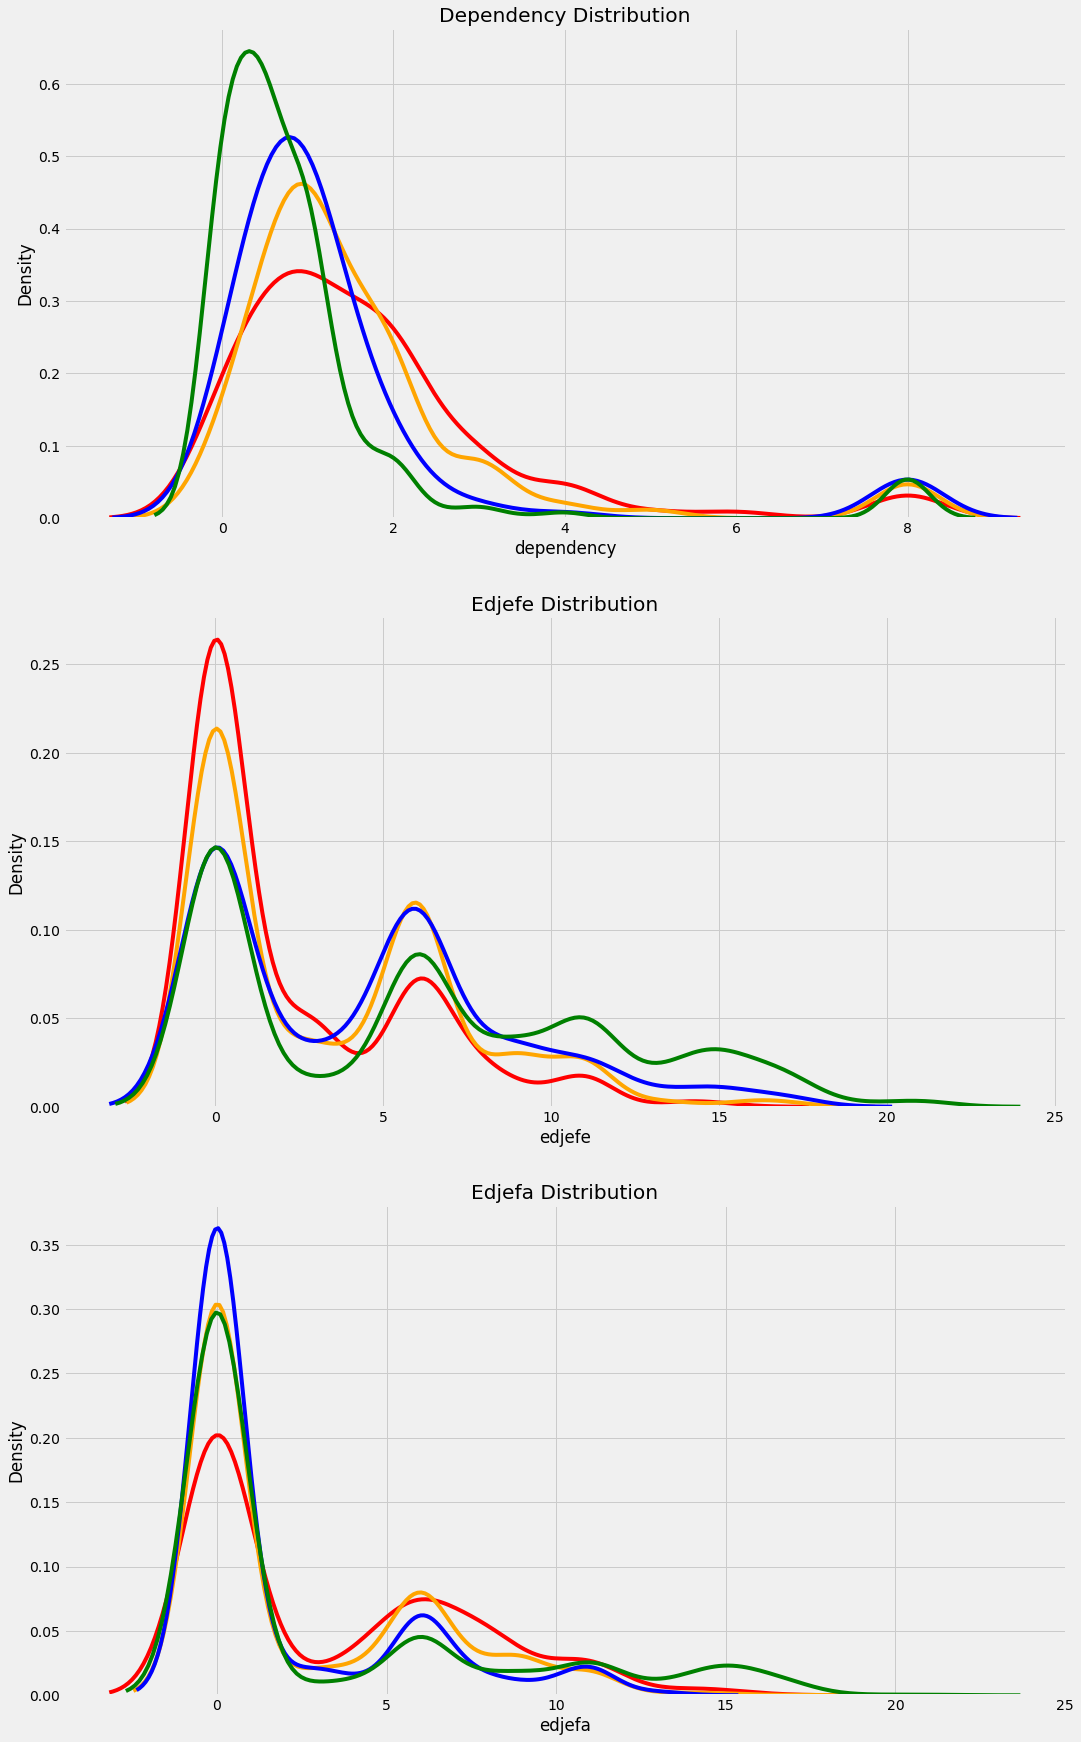

In [ ]:
plt.figure(figsize=(16,12))

for i, col in enumerate(['dependency','edjefe','edjefa']) :
  ax=plt.subplot(3,1,i+1)

  for poverty_level, color in colors.items() :
    sns.kdeplot(train.loc[train['Target']==poverty_level, col].dropna(), ax=ax, color=color, label = poverty_mapping[poverty_level])

  plt.title(f'{col.capitalize()} Distribution'); plt.xlabel(f'{col}'); plt.ylabel('Density')

plt.subplots_adjust(top = 2)

In [ ]:
# add null target columns to test

test['Target'] = np.nan
data = train.append(test, ignore_index=True)



In [ ]:
data.tail()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
33408,ID_a065a7cad,NaN,1,2,1,1,1,0,NaN,0,...,9,100,36,25,4,36.0,0.25,33.0625,100,NaN
33409,ID_1a7c6953b,NaN,0,3,0,1,1,0,NaN,0,...,36,2916,16,36,4,4.0,1.00,36.0000,2916,NaN
33410,ID_07dbb4be2,NaN,0,3,0,1,1,0,NaN,0,...,16,144,16,36,4,4.0,1.00,36.0000,144,NaN
33411,ID_34d2ed046,NaN,0,3,0,1,1,0,NaN,0,...,25,144,16,36,4,4.0,1.00,36.0000,144,NaN
33412,ID_34754556f,NaN,0,3,0,1,1,0,NaN,0,...,36,2601,16,36,4,4.0,1.00,36.0000,2601,NaN


##Exploring Label Distiribution

To look at the correct labels, well subset only to the columns where parentesco == 1 because this i sthe head of household, the corect label for each household.

1.0     222
2.0     442
3.0     355
4.0    1954
Name: Target, dtype: int64

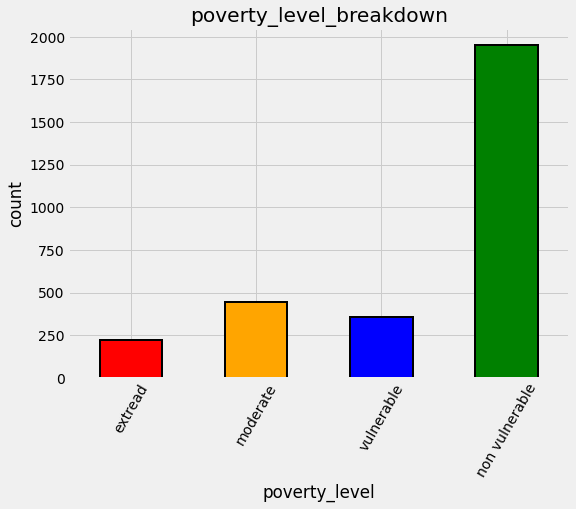

In [ ]:
#Heads of household

heads = data.loc[data['parentesco1'] ==1].copy()

#labels for training
train_labels = data.loc[(data['Target'].notnull()) & (data['parentesco1'] ==1), ['Target','idhogar']]

#values counts of target
label_counts = train_labels['Target'].value_counts().sort_index()

#bar plot of occurrences of each label
label_counts.plot.bar(figsize=(8,6),color=colors.values(),edgecolor='k', linewidth=2)

#formatting
plt.xlabel('poverty_level');plt.ylabel('count');plt.xticks([x-1 for x in poverty_mapping.keys()],
                                                           list(poverty_mapping.values()), rotation=60)
plt.title('poverty_level_breakdown')

label_counts

###Addressing Wrong Labels


In [ ]:
#groupby the household and figure out the number of unique values
all_equal = train.groupby('idhogar')['Target'].apply(lambda x : x.nunique() ==1)
all_equal
#households where targets are not all equal
not_equal = all_equal[all_equal != True]

print('there are {} households where the family members do not all have the same target'.format(len(not_equal)))


There are 85 households where the family members do not all have the same target.


In [ ]:
train[train['idhogar'] == not_equal.index[0]][['idhogar','parentesco1', 'Target']]

,idhogar,parentesco1,Target
7651,0172ab1d9,0,3
7652,0172ab1d9,0,2
7653,0172ab1d9,0,3
7654,0172ab1d9,1,3
7655,0172ab1d9,0,2


Families without heads of household

In [ ]:
households_leader = train.groupby('idhogar')['parentesco1'].sum()

#find households without a head
households_no_head = train.loc[train['idhogar'].isin(households_leader[households_leader ==0].index), :]

print('there are {} households without a head'.format(households_no_head['idhogar'].nunique()))

there are 15 households without a head


In [ ]:
# Find households without a head and where labels are different
households_no_head_equal = households_no_head.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)
print('{} Households with no head have different labels.'.format(sum(households_no_head_equal == False)))

0 Households with no head have different labels.


correct Errors

Now we can correct labels for the households that do have a head and the members have different poverty levels.

In [ ]:
# Iterate through each household
for household in not_equal.index:
    # Find the correct label (for the head of household)
    true_target = int(train[(train['idhogar'] == household) & (train['parentesco1'] == 1.0)]['Target'])
    
    # Set the correct label for all members in the household
    train.loc[train['idhogar'] == household, 'Target'] = true_target
    
    
# Groupby the household and figure out the number of unique values
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

# Households where targets are not all equal
not_equal = all_equal[all_equal != True]
print('There are {} households where the family members do not all have the same target.'.format(len(not_equal)))

There are 0 households where the family members do not all have the same target.


##Missing Variables

ONe of the most important steps of exploratory data analysis is finding missing values in the data and determining how to handle them. Missing values have to be filled in before we use a ML model and we need to think of the best strategy for filling them in based on the feature : this is where we'll have to start digging into the data definitions.

In [ ]:
#missing in each column
missing = pd.DataFrame(data.isnull().sum()).rename(columns={0:'total'})

missing
#create a percentage missing
missing['percent'] = missing['total'] / len(data)

missing.sort_values('percent', ascending=False).head(10).drop('Target')

,total,percent
rez_esc,27581,0.825457
v18q1,25468,0.762218
v2a1,24263,0.726154
SQBmeaned,36,0.001077
meaneduc,36,0.001077
hogar_adul,0,0.000000
parentesco10,0,0.000000
parentesco11,0,0.000000
parentesco12,0,0.000000


Function to Plot Value counts

In [ ]:
def plot_value_counts(df, col, heads_only = False) :
  '''plot value counts of a column, optionally with only the heads of a household'''

  #select heads of household
  if heads_only :
    df = df.loc[df['parentesco1'] ==1].copy()

  plt.figure(figsize=(8,6))
  df[col].value_counts().sort_index().plot.bar(color='blue', edgecolor='k', linewidth=2)

  plt.xlabel(f'{col}')
  plt.title(f'{col} Value counts')
  plt.ylabel('count')
  plt.show()

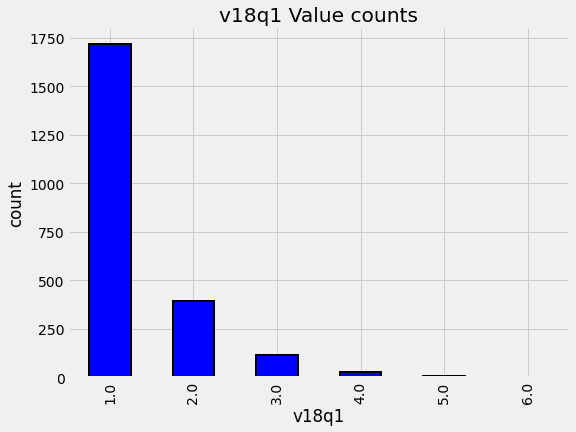

In [ ]:
plot_value_counts(heads, 'v18q1')

In [ ]:
heads.groupby('v18q')['v18q1'].apply(lambda x : x.isnull().sum())

v18q
0    8044
1       0
Name: v18q1, dtype: int64

In [ ]:
data['v18q1'] = data['v18q1'].fillna(0)

Text(0.5, 1.0, 'home ownership status for households missing rent payments')

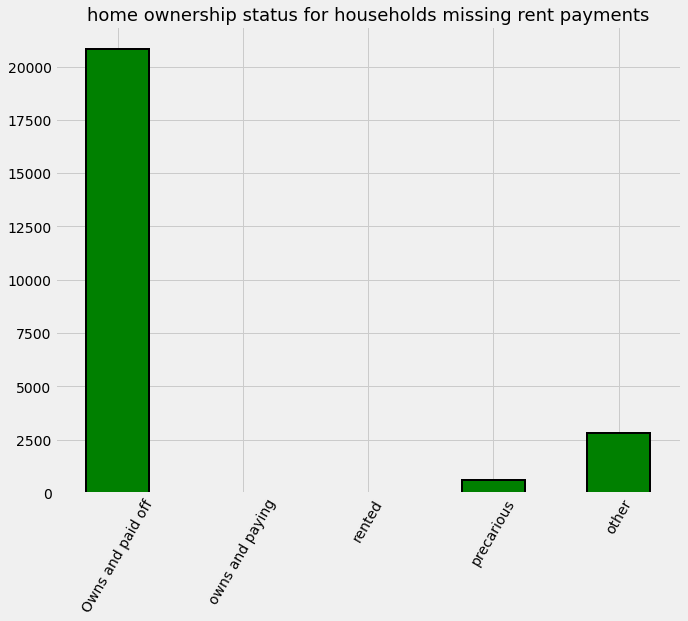

In [ ]:
# Variales indicating home ownership
own_variables = [x for x in data if x.startswith('tipo')]

#plot of the home ownership variables for home missing rent payments
data.loc[data['v2a1'].isnull(), own_variables].sum().plot.bar(figsize=(10,8), color='green', edgecolor='k', linewidth=2)

plt.xticks([0,1,2,3,4], ['Owns and paid off','owns and paying','rented','precarious','other'], rotation=60)

plt.title('home ownership status for households missing rent payments', size=18)

In [ ]:
#fill in households that own the house with 0 rent payment

data.loc[data['tipovivi1'] ==1, 'v2a1'] =0

#create missing rent payment column
data['v2a1-missing'] = data['v2a1'].isnull()

data['v2a1-missing'].value_counts()

False    29994
True      3419
Name: v2a1-missing, dtype: int64

In [ ]:
data.loc[data['rez_esc'].notnull()]['age'].describe()

count    5832.000000
mean       12.185700
std         3.198618
min         7.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        17.000000
Name: age, dtype: float64

In [ ]:
#if individual is over 19 or younger than 7 and missing years behind, set it to 0

data.loc[((data['age'] >19) | (data['age']<7 )) & (data['age'].isnull()), 'rez_esc'] =0

#add a flag for those btw 7 and 19 with a missing value
data['rez_esc-missing'] = data['rez_esc'].isnull()

In [ ]:
data.loc[data['rez_esc'] >5, 'rez_esc'] = 5

##Plot Two Categorical Variables

To show how two categorical variables interact with one another, there are  a number of plotting options : scatterplots, faceted bar plots, boxplots, etc. I wasnt satisfied with any of these choices so i wrote the function below, which esssentially is a scatterplot of two catgoricals where the size of the points represent the percentage of a given y-value represented by each x-value.

In [ ]:
def plot_categoricals(x,y,data, annotate=True) :
  '''plot counts of two categoricals.
  Size is raw count for each grouping.
  Percentages are for a given value of y'''

  #raw counts
  raw_counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize=False))

  raw_counts= raw_counts.rename(columns={x:'raw_count'})

  counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize=True))

  counts=counts.rename({x:'normalized_count'}).reset_index()
  counts['percent'] = 100 * counts['normalized_count']

  #ada the raw counts

  counts['percent'] = list(raw_counts['raw_count'])

  plt.figure(figsize=(14,10))

  #scatter plot sized by percent
  plt.scatter(counts[x], counts[y], edgecolot='k', color='lightgreen',
              s=100*np.sqrt(counts['raw_count']), marker='o', alpha=0.6, linewidh=1.5)


  if annotate :
    #Annotate the plot with text
    for i, row in counts.iterrows() :
      #put texy with appopriate offsets
      plt.annotate(xy=(row[x] - (1/counts[x].nunique()), row[y] - (0.15/counts[y].nunique())),
                   color='navy', s = f"{round(row['percent'], 1)}%")


  #set tick marks
  plt.yticks(counts[y].unique())
  plt.xticks(counts[x].unique()) 

  #Transform min and max to evenly space in square root domain
  sqr_min = int(np.sqrt(raw_counts['raw_count'].min()))
  sqr_max = int(np.sqrt(raw_counts['raw_count'].max()))

  #5 sizes for legend
  msizes = list(range(sqr_min, sqr_max, int(( sqr_max - sqr_min) /5)))

  markers=[]

  #Markers for legend
  for size in msizes :
    markers.append(plt.scatter([],[], s=100 * size, label=f'{int(round(np.square(size) / 100) * 100)}',
                               color='lightgreen', alpha=0.6, edgecolor='k', linewidth=1.5))
    
  #legned and formatting
  plt.legend(handles=markers, title='count',
             labelspacing = 3, handletextpad = 2,
             fontsize=16, loc=(1.10,0.19))
  
  plt.annotate(f'* size represents raw count while % is for a given y value.', xy=(0,1), xycoords='figure points', size=10)

  #Adjust axes limits
  plt.xlim( (counts[x].min() - (6 / counts[x].nunique()),
              counts[x].max() + (6/counts[x].nunique())))
  plt.ylim( (counts[y].min() - (4/counts[y].nunique()),
             counts[y].max() - (4/counts[y].nunique())))
  
  plt.grid(None)
  plt.xlabel(f'{x}')
  plt.ylabel(f'{y}')
  plt.title(f'{y} vs {x}')


In [ ]:
plot_categoricals('rez_esc', 'Target', data)

ValueError: ignored

In [ ]:
plot_categoricals('escolari','Target', data, annotate=False)

ValueError: ignored

In [ ]:
plot_value_counts(data[(data['rez_esc_missing'] ==1)], 'Target')

KeyError: ignored

#Feature Engineering

There is plenty more eda we can do, but first we should work on consolidating out data at a household level. WE already have some of the information for each household bur for training, we will need all of the information summarized for each household. This means grouping the individuals in a house groupby and performing and aggregatino agg of the individual varialbes.



##Column Definitions

The process is as follows
1. Break variables into household level and individual level
2. Find suitable aggregations for the individual level data
- Ordinal variables can use statistical aggregation
- Boolean variables can also be aggregated but with fewer stats

3. join the individual aggregations to the household level data

###Define Variable Categories

there are several different categories of variables :

1. Individual variables : these are characterstics of each individual rather than the household
- Boolean : 0 or 1
- ordered discrete : integers with an ordering

2. Household variables
- boolean : y or n
- orderd discrete : integers with an ordering
- continuous numeric

3. squared variables : derived from squaring variables in the data
4. id variables : identifies the data and should not be used as features



In [ ]:
id=['Id','idhogar','Target']

In [ ]:
ind_bool = ['v18q', 'dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 
            'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
            'parentesco1', 'parentesco2',  'parentesco3', 'parentesco4', 'parentesco5', 
            'parentesco6', 'parentesco7', 'parentesco8',  'parentesco9', 'parentesco10', 
            'parentesco11', 'parentesco12', 'instlevel1', 'instlevel2', 'instlevel3', 
            'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 
            'instlevel9', 'mobilephone', 'rez_esc-missing']

ind_ordered = ['rez_esc', 'escolari', 'age']

In [ ]:
hh_bool = ['hacdor', 'hacapo', 'v14a', 'refrig', 'paredblolad', 'paredzocalo', 
           'paredpreb','pisocemento', 'pareddes', 'paredmad',
           'paredzinc', 'paredfibras', 'paredother', 'pisomoscer', 'pisoother', 
           'pisonatur', 'pisonotiene', 'pisomadera',
           'techozinc', 'techoentrepiso', 'techocane', 'techootro', 'cielorazo', 
           'abastaguadentro', 'abastaguafuera', 'abastaguano',
            'public', 'planpri', 'noelec', 'coopele', 'sanitario1', 
           'sanitario2', 'sanitario3', 'sanitario5',   'sanitario6',
           'energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4','elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 
           'elimbasu5', 'elimbasu6', 'epared1', 'epared2', 'epared3',
           'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 
           'tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5', 
           'computer', 'television', 'lugar1', 'lugar2', 'lugar3',
           'lugar4', 'lugar5', 'lugar6', 'area1', 'area2', 'v2a1-missing']

hh_ordered = [ 'rooms', 'r4h1', 'r4h2', 'r4h3', 'r4m1','r4m2','r4m3', 'r4t1',  'r4t2', 
              'r4t3', 'v18q1', 'tamhog','tamviv','hhsize','hogar_nin',
              'hogar_adul','hogar_mayor','hogar_total',  'bedrooms', 'qmobilephone']
 
hh_cont = ['v2a1', 'dependency', 'edjefe', 'edjefa', 'meaneduc', 'overcrowding']

In [ ]:
sqr_ = ['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 
        'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq']

Let's make sure we covered all of the variables and didnt repeat any

In [ ]:
x=ind_bool + ind_ordered + id_ + hh_bool + hh_ordered + hh_count + sqr_

from collections import Counter

print('there are no repeats :', np.all(np.array(list(Counter(x).values())) ==1))
print('we covered every variable :', len(x) ==data.shape[1])

Squared Variables

First, the easies step : we'll remove all of the squared variables. Sometimes, variables are square or transformed as part of feature engineering because it can help linear models learn relationship that are non-linear. However, since we will be useing more complex models these squares features are redundant. They are highly correlated with the non-squared version, and hence can actually hurt out model by adding irrelevant infromation and also slowing down training.

In [ ]:
sns.lmplot('age','SQBage', data=data, fig_reg = False);
plt.title('Squared age versus age :')

In [ ]:
data= data.drop('sqr_')
data.shape

###Id Variables

###Household Level Variables

In [ ]:
heads=  data.loc[data['parentesco1' ] ==1, :]
heads = heads[id_ + hh_bool + hh_cont + hh_ordered]
heads.shape

Redundant Household Variables

Let's take a look at the correlations btw all of the household variable. If there are any that are too highly correlated, when we might want to remove one of the pair of highly correlated variables.

The following code identifies any variables with a greater than 0.95 absolute magnitude correlation.

In [ ]:
#create correlation matrix
corr_matrix = heads.corr()

#Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

#Find index of feature columns with correlation greater than 0.95

to_drop = [column for column in upper.column if any(any(abs(upper[column]) >0.95)]

to_dro

In [ ]:
corr_matrix.loc[corr_matrix['tamhog'].abs() >0.9, corr_matrix['tamhog'].abs >0.9]

In [ ]:
sns.heatmap(corr_matrix.loc[cor_matrix['tamhog'].abs() >0.9, corr_matrix.loc['tamhog'].abs() >0.9],
            annot=True, cmap = plt.cm.autumn_r, fmt='.3f')

In [ ]:
heads = heads.drop(['tamhog','hogar_total','r4t3'], inplace=True)

In [ ]:
sns.lmplot('tamviv', 'hhsize', data, fit_reg=False, size = 8);
plt.title('Household size vs number of persons living in the household');

In [ ]:
heads['hhsize-diff'] = heads['tamviv'] - heads['hhsize']
plot_categoricals('hhsize-diff', 'Target', heads)

In [ ]:
corr_matrix.loc[corr_matrix['coopele'].abs() > 0.9, corr_matrix['coopele'].abs() > 0.9]

Creating Ordinal Variable

0: No electricity
1: Electricity from cooperative
2: Electricity from CNFL, ICA, ESPH/JASEC
3: Electricity from private plant

In [ ]:
elec = []

for i, row in heads.iterrows() :
  if row['noelec'] ==1 :
    elec.append(0)
  elif row['coopele'] ==1 :
    elec.append(1)
  elif row['public'] == 1:
    elec.append(2)
  elif row['planpri'] == 1:
    elec.append(3)
  else:
    elec.append(np.nan)
        
# Record the new variable and missing flag
heads['elec'] = elec
heads['elec-missing'] = heads['elec'].isnull()

# Remove the electricity columns
# heads = heads.drop(columns = ['noelec', 'coopele', 'public', 'planpri'])

In [ ]:
plot_categorical('elec',' Target', heads)

In [ ]:
heads = heads.drop(columns = 'area2')

heads.groupby('area1')['Target'].value_counts(normalize = True)

###Creating Ordinal Variables

For the walls, roof, and floor of the house, there are three columns each : the first indicating 'bad', the second 'regular', and the third 'good'. We could leave the variables as booleans, but to me it makes more sense to turn them into ordinal variables because there is an inherent order  : bad < regular < good. To do this, we can simply find whichever column is non-zero for each household using np.argmax.

In [ ]:
#wall ordinal variable
heads['walls'] = np.argmax(np.array(heads[['epared1','epared2','epared3']]), axis=1)

#heads = heads.drop(['~~],axis=1)
plot_categoricals('walls','Target', heads)

In [ ]:
# Roof ordinal variable
heads['roof'] = np.argmax(np.array(heads[['etecho1', 'etecho2', 'etecho3']]),
                           axis = 1)
heads = heads.drop(columns = ['etecho1', 'etecho2', 'etecho3'])

# Floor ordinal variable
heads['floor'] = np.argmax(np.array(heads[['eviv1', 'eviv2', 'eviv3']]),
                           axis = 1)
# heads = heads.drop(columns = ['eviv1', 'eviv2', 'eviv3'])

Feature Construction

In addtion to mapping variables to ordinal features, we can also create entirely new features from the existing data, known as feature construction. For example, we can add up the previous three features we just created to get an overall measure of the quality of the hous's structure.

In [ ]:
#create new feature
heads['walls+roof+floor'] = heads['walls']+heads['roof']+['floor']


plot_categorical('walls+roof+floor', 'Target', hads, annotate=False)

In [ ]:
counts = pd.DataFrame(heads.groupby(['walls+roof+floor'])['Target'].value_counts(normalize=True)).rename({'Target' : 'Normalized Count'}).reset_index()

counts.head()

In [ ]:
#No toilet, no electricity, no fllor, no water service, no ceiling
head['warning'] = 1*((heads['sanitario1']) + (heads['elec'] ==0) + (heads['pisonotiene']) + (heads['abastaguano']) + (heads['cielorazo'] ==0))



In [ ]:
plt.figure(fitsize=(10,6))
sns.violinplot('warning', 'Target', data=heads)
plt.title('Target vs Warning Variable')

In [ ]:
plot_categoricals('warning', 'Target', data=heads)

In [ ]:
#owns a refrigerator, computer, talbet, and television

heads['bonus'] = 1 * ( (heads['refrig'] + (heads['computer']) + (heads['v18q1'] >0) + (heads['television'])


sns.violinplot('bonus','Target', data=heads)

plt.title('Target vs Bonus Variable')

##Per Capita Features

Additional features we can make calculate the numver of certain measurements for each person in the household

In [ ]:
heads['phones-per-capita'] = heads['qmobilephone'] / heads['tamviv']
heads['tablets-per-capita'] = heads['v18q1'] / heads['tamviv']
heads['rooms-per-capita'] = heads['rooms'] / heads['tamviv']
heads['rent-per-capita'] = heads['v2a1'] / heads['tamviv']

##Exploring Household Variables

After going to all the trouble of getting our features in drder, now we  can take a look at them in relation to the Target. WE've already done a little fo this, but now we can try to quatify realtionships.

Measuring Relationships

Threr are many ways for measuring relationships btw two variables. Here we will examine two of these :

1. The Pearson Correleation
2. The Spearman Correlation : from -1 to 1 measring the ***monotonic relationship*** btw two variables

In [ ]:
from scipy.stats import spearmanr

In [ ]:
def plot_corrs(x,y) :
  '''plot data and show the spearman and pearson corrleation '''

  #calclute correlations
  spr = spearmanr(x,y).correlation
  pcr = np.corrcoef(x,y)[0,1]

  #scatter plot
  data =pd.DataFrame({'x':x,'y':y})
  plt.figure(figsize=(4,6))
  sns.regplot('x','y', data=data, fit_reg=False)
  plt.title(f'spearman : {round(spr,2)}, pearson : {round(pcr,2)}');

In [ ]:
x=np.array(range(100))
y=x**2

plot_corrs(x,y)

First, well calculate the pearson correlation of every variable with the target

In [ ]:
#use only training data
train_heads = heads.loc[['Target'].notnull(), :].copy()

pcorrs = pd.DataFrame(train_heads.corr()['Target'].sort_values()).rename({'Target' : 'pcorr'}, aixs=1).reset_index()
pcorrs = pcorrs.rename({'index' : 'feature'}, axis=1)

print('Most negatively correlated vaiables' :)
print(pcorrs.head())

print('\n Most positively correlated variables :')
print(pcorrs.dropna().tail())

Now we cna move on to the Spearman correlation

In [ ]:
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

feats  = []
scorr = []
pvalues = []

#iterate through each column
for c in heads :
  #only valid for numbers
  if heads[c].dtype != 'object' :
    feats.append(c)

    #calculate spearman correlation
    scorr.append(spearmanr(train_heads[c], train_heads['Target']).correlation)
    pvalues.append(sparmanr(train_heads[c], train_heads['Target'].pvalue)

corrs=pd.DataFrame({'feature' : feats, 'scorr' : scorr, 'pvalue' : pvalues}).sort_values('scorr')

In [ ]:
print('most negarive spearman correlations :')
print(scorrs, head())

print('\n most posirive spearman correlations :')
print(scorrs. tail())

In [ ]:
corrs=pcorrs.merge(scorrs.on='feature')

corrs['diff'] = corrs['pcorrs'] - corrs['scorr']

corrs.sort_values('diff').head()

In [ ]:
corrs.sort_values('diff').dropna().tail()

In [ ]:
sns.lmplot('dependency', 'Target', fig_reg = True, data = train_heads, x_jitter=0.05, y_jitter=0.05)
plt.title('Target vs Depnedency')

It's hard to see the relationship, but its slightly negative : as the dependency increases, the value of the target decreases. This makes sense : dependency is the # dependent individuals divided by the number of non-dependents. AS we increase thi svalues, the poverty severty tends to increase : having more dependent family members (who usually are non-working) leads to higher levels of povery because they must be supported by the non dependent family members.

In [ ]:
sns.lmplot('rooms-per-capita', 'Target', fit_reg=True, data=train_heads, x_jitter=0.05, y_jitter=0.05);
plt.title('Target vs Rooms per capita');

Correlation heatmap

In [ ]:
variables = ['Target', 'dependency', 'warning', 'walls+roof+floor', 'meaneduc',
             'floor', 'r4m1', 'overcrowding']

#calculate the correlations
corr_mat = train_heads[variables].corr().round()

#draw a correlation heatmap
plt.rcParams['font.size']=18
plt.figure(figsize(12,12))
sns.heatmap(corr_mat, vmax=0.8,vmin=-0.5, cmap=plt.cm.RdYlGn_r,annot=True)

Features plot

For the final exploration of the household level data, we can make a plot of some of the most correlated variables with the Target. This shows scatterplots on the upper triangle, kernel density estimate(kdeplot) on the diagonla, and 2d kde plots on the lower triangle.

In [ ]:
import warnings

#copy the data for plotting
plot_data = train_heads[['Target', 'dependency','walls+roof+floor','meanuduc','overcrowding']]

#Create the parigrid object
grid = sns.PairGrid(data = plot_data, size=4, diag_sharey=False, hue='Target', hue_order=[4,3,2,1],
                    vars = [ x for x in list(plot_data.columns) if x != 'Target'])

grid.map_upper(plt.scatter, alpha=0.8,s=20)

#diagonal is a histogram
grid.map_diag(sns.kdeplot)

#Bottom is densiy plot
grid.map_lower(sns.kdeplot, cmap=plt.cm.OrRd_R);
grid=grid.add_legend()
plt.suptitle('Feature plots colored by target', size=32, y=1.05);

In [ ]:
household_feats = list(heads.columns)

#Individual Level Variables

There are two types of individual level variables : Boolean or ordinal

In [ ]:
ind = data[id + ind_bool + ind_ordered ]

ind.shape

Redundant Individual Variables

In [ ]:
#create correlation matrix
corr_matrix = ind.corr()

#select upper triangle of correlation matric
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

#find index of feature columns with coorelation greater than 0.95
to_drop = [columns for column in upper.columns if any(abs(upper[column] >0.95))]

In [ ]:
ind=ind.drop('male',axis=1)

Creating Ordinal variables

In [ ]:
ind [[c for c in ind if c.startswith('instl')]].head()

In [ ]:
ind['inst'] = np.argmax(np.array(ind[[c for c in ind if c.startswith('instl')]]), axis = 1)

plot_categoricals('inst', 'Target', ind, annotate = False)

In [ ]:
plt.figure(figsize = (10, 8))
sns.violinplot(x = 'Target', y = 'inst', data = ind);
plt.title('Education Distribution by Target');

In [ ]:
# drop the ecudation column
# ind = ind.drop(columns = [c for c in ind if c.startswith('instlevel')])
int.shape

Feature Construction

In [ ]:
ind['escolari/age'] = ind['escolari'] / ind['age']

plt.figure(figsize=(10,6))
sns.violinplot('Target', 'escolari/age', data=ind)

In [ ]:
ind['inst/age'] = ind['inst'] / ind['age']
ind['tech'] = ind['v18q'] + ind['mobilephone']
ind['tech'].describe()

Feature Engineering through Aggregations

In order to incorporate the individual data into the household data, we need to aggregate it for each household. The simplest way to do this is to groupby the family id idhogar and then agg the data. For the aggregatiosn for ordered or continuous varialbe,s we can use six, five of which are built in to pands, and one of which we define ouselves range_.

In [ ]:
#define custom function
range_ = lambda x : x.max() - x.min()
range_.__name__ = 'range_'

#group the aggregate
ind_agg = ind.drop(columnds='Target').groupby('idhogar').agg(['min','max','sum','count','std',range_])
ind_agg.head()

In [ ]:
#rename the columns
new_col = []
for c in ind_agg.columns.levles[0] :
  for stat in ind_agg.columns.lelvels[1] :
    new_col.append(f'{c}-{stat}')

ind_agg.columns = new_col
ind_agg.head()

In [ ]:
ind_agg.iloc[:, [0, 1, 2, 3, 6, 7, 8, 9]].head()

Feature Selection

As a first round of feature sleection, we can remove on e out of every pair of varialbe swith a correlation greater than 0.95

In [ ]:
# Create correlation matrix
corr_matrix = ind_agg.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

print(f'There are {len(to_drop)} correlated columns to remove.')

In [ ]:
ind_agg = ind_agg.drop(columns = to_drop)
ind_feats = list(ind_agg.columns)

# Merge on the household id
final = heads.merge(ind_agg, on = 'idhogar', how = 'left')

print('Final features shape: ', final.shape)

Final data Exploration

In [ ]:
corrs = final.corr(['Target'])

In [ ]:
corrs.sort_values().head()

In [ ]:
corrs_sort_values().dropna().tail()

In [ ]:
plot_categoricals('escolari-max','Target', final, annotate=False)

In [ ]:
plt.figure(figsize = (10, 6))
sns.violinplot(x = 'Target', y = 'escolari-max', data = final);
plt.title('Max Schooling by Target');


In [ ]:
plt.figure(figsize = (10, 6))
sns.boxplot(x = 'Target', y = 'escolari-max', data = final);
plt.title('Max Schooling by Target');

In [ ]:
plt.figure(figsize = (10, 6))
sns.boxplot(x = 'Target', y = 'meaneduc', data = final);
plt.xticks([0, 1, 2, 3], poverty_mapping.values())
plt.title('Average Schooling by Target');

In [ ]:
plt.figure(figsize = (10, 6))
sns.boxplot(x = 'Target', y = 'overcrowding', data = final);
plt.xticks([0, 1, 2, 3], poverty_mapping.values())
plt.title('Overcrowding by Target');

In [ ]:
head_gender = ind.loc[ind['parentesco1'] == 1, ['idhogar', 'female']]
final = final.merge(head_gender, on = 'idhogar', how = 'left').rename(columns = {'female': 'female-head'})

In [ ]:
final.groupby('female-head')['Target'].value_counts(normalize=True)

#Machine Learning Modeling

Once feature engineering/construction is done, we can get started with the ML. All of our data is aggregated for each household and so can be directly used in a model. To first show the process of modeling, we'll use the capable ***RFC*** in Scikit-Learn. This probably wont get us to the top of the leaderboard, but it will allow us to establish a baseline. Later, We'll try several other models including the powerful Gradient Boosting Machine.

To assess our model, we'll use ***10-fold cross validation*** on the training data

then we use the F1 Macro measure to evaluate performance.

In [ ]:
from skelarn.ensemble import RandomForestClassifier
from sklearn.metrics import f1score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.Imputer import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipleline import Pipeline

#custom scorer for cross validation
scorer = make_scorer(f1_score, greater_is_beter=True,avergage='macro')

In [ ]:
#labels for training
train_labels = n.array(list(final[final['Target'].notnull()]['Target'].astype(np.unit8)))

#Extract the training data
train_set = final[final['Target'].notnull()].drop(columns=['id','idhogar','Target'])

test_set = filna[final['Target'].isnull()].drop(columns=['Id','idhogar','Target'])

#Submission base which is used for making submissions to the competition
submission_base = test[['id','idhogar'], index=False].copy()

In [ ]:
features = list(train_set.columns)

pipeline = Pipeline([ ('imputer', SimpleImputer(strategy='median')), ('scaler', MinMaxScaler())])

#Fit the transform training data
train_set = piepline.fit_transform(train_set)
test_set = pipeline.transform(test_set)

In [ ]:
model = RandoForestClassifier(n_estimators =100, random_state =42, n_jobs=-1)


#10 fold cross validation
cv_score = cross_Val_score(model, train_set, train_labels, cv=10, scoring = scorer)

print(f'10 fold cross validtiaon f1 score : {round(cv_score.mean(),4)} with std = {round(cv_score.std(),4)}')

Feature Importances

With a tree-based model, we cna look at the feature importances which show a relative ranking of the usefulness of features in the model. These represent the sum of the reduction in impurity at nodes that used the variable for splitting, but we don't have to pay much attention to the absolute value. Instead we'll focus on relative scores.

If we wnat to view the feature importances, we'll have to train a model on the whole training set. Corss validation does not return the feature importnaces.

In [ ]:
model.fit(train_Set, train_labels)

#Featrue importances into a dataframe
feature_importances = pd.DataFrame({'feature' : feautures, 'importance' : model.feature_importances_})
feature_iportances.head()

In [ ]:
def plot_feature_importances(df, n=10, threshold = None) :
  '''plots n most important features. Also plots the cumulative importance if threshold is specified and prints the number of features needed to reach threshold cumulative importance. Intended for use with any tree-based feature importances.
  '''
  plt.style.use('fivethirtyeight')

  #sort features with most important at the head
  df = df.sort_values('importance', ascending=False).reset_index(drop=True)

  #normalize the feature importances to add up to one and calcula te cumulative importance
  df['importance_normalized'] = df['importance'] / df['importance'].sum()
  df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

  plt.rcParams['font_size']=12

  #bar plot of n most importnat feature
  df.loc[:n,:].plot.barh(y='importnace_normalized',
                         x='feature', color='darkgreen', edgecolor='k', figsize=12,
                         legend=False, figsize=(12,8))

  plt.xlabel('Normalized Importnace', size=18);plt.ylabel('');
  plt.title(f'{n} Most Important FEatures', size=18)
  plt.gca().inver_yaxis()


  if threshold :
    #cumulative importance plot
    plt.figure(figsize=(8,6))
    plt.plot(list(range(len(df))), df['cumulative_importnace'], 'b-')
    plt.xlabel('Number of FEatures', size=16);
    plt.ylabel('Cumulative importance',size=16);
    plt.title('Cumulative feature importance',size=18);

    #number of feature needed for threshold cumulative importnace
    #this i sthe index
    importrnace_index = np.min(np.where(df['cumulative_importance'] >threshold))


    #add vertical line to plot
    plt.vlines(importance_index +1 , ymin=0, ymax=1.05, linestyles = '--', colors='red')
    plt.show()

    print('{}features required for {:.0f}% of cumulative importance'.format(importance_index +1, 100*threshold))

    return df
  

In [ ]:
norm_fi = plot_Feature_importances(feature_importances, threshold=0.95)

In [ ]:
def kde_target(df, variable) :
  '''plots the distribution of 'variable'in df colored by the target column'''

  colors = {1 : 'red', 2: 'orange', 3:'blue', 4:'green'}

  plt.figure(figsize=(12,8))

  df=df[df['Target'].notnull()]

  for level in df['Target'].unique() :
    subset = df[df['Target'] ==levle].copy()
    sns.kdeplot(subset[variable].dropna(),
                label=f'Poverty Level : {level}',
                color = colors[int(subset['Target'].unique())])

    
    plt.xlabel(variable);plt.ylabel('Density');
    plt.title('{}distribution'.format(variable.capitalize()))

In [ ]:
kde_target(final, 'meanduc')

#Model Selection

In [ ]:
#model imports
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV
from sklearn.discriminant_anylysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning

#filter out warnings from models
warnings.filterwarnings('ignore', category = ConvergenceWarning)
warnings.filterwarnings('ignore', category = DeprecationWArning)
warnings.filterwarnings('ignore', category = UserWarning)


#df to hold results
model_results = pd.DataFrame(columns = ['model','cv_mean','cv_std'])

def cv_model(train, train_labels, model, name, model_results = None):
  '''perform 10 fold cross validation fo a model'''

  cv_scores = cross_val_score(model, train, train_labels, cv=10, scoring= scorer, n_jobs=-1)

  print(f'10 folds CV score : {round(cv_scores.mean(),5)} with std : {round(cv_scores.std(),5)}')

  if model_results is not None :
    model_results = model_results.append(pd.DataFrame({'model' : name, 'cv_mean' : cv_scores_mean(), 'cv_std' : cv_scores.std()}),index=[0], ignore_index=True)
    return model_results

In [ ]:
model_results = cv_model(train_set, train_labels, GaussianNB(), 'GNB', model_results)

That performance is very poor. I dont think we need to revisit the Gaussian NB method.

In [ ]:
model_results = cv_model(train_set, trai_labels, MLPClassifier(hidden_layer_sizes=(32,64,128,64,32)), 'MLP', model_results)



The multi-perceptron has decent performance. This might be an option if w e are able to hyperparameter tune the network. However, the limited amount of data could be  an issue with a neural network as  these generally require hundres of thousands of examples to learn effectively.

In [ ]:
model_results = cv_model(train_set, train_labels, LinearDiscriminantAnalysis(), 'LDA', model_results)

If you run LDA without filtering out the UserWarnings, you get many messages saying ' Variables are collinear'. This might give us a hint that ***we want to remove some collinear features***. We might want to try this model again after remwoving the collinear variables because the score is comparable to the random forest.

In [ ]:
model_results = cv_model(train_set, train_labels, RidgeClassiiferCV(), 'RIDGE', model_results)

The linear model(with ridge regularization) does surpsingly well. this might indicate that a simple model can go a long way in this problem

In [ ]:
for n in [5,10,20] :
  print(f'\n KNN with {n} neighbors\n')
  model_results = cv_model(train_set, train_labels, KNeighborsClassifier(n_neighbors=n), f'knn-{n}', model_results)

As one more attempt, well consider the EXTC, a Variant on the random forest using ensembles of decision trees as well.

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier as EXTC

model_results = cv_model(train_set, train_labels, EXTC(n_estimators=100, random_state=42), 'EXT', model_results)

##comparing model Performance

With the modeling results in a df, we can plot them to see which model does the best

In [ ]:
model_results = cv_model(train_set, train_labels, RandomForestClassifier(n_estimators=100, random_state=42), 'RF', model_results)

In [ ]:
model_results.set_index('model', inplace=True)
model_results['cv_mean'].plot.bar(color='orange', figsize=(8,6), yerr = list(model_results['cv_std']),
                                  edgecolor='k', linewidth=2)

plt.title('Model F! Score Results')
plt.xlable('Each Models'); plt.yalabel('Mean F1 Score (with error bar)')
model_results.reset_index(inplace=True)

The most likely candidate seems to be the RF bcuz it does best right out of the box. While we didnt tune any of the hyperparameters so the comparison btw models is not perfect, these results reflect those of many other Kaggle competitors finding that ***tree-based ensemble methods perform very well on structures datasets***. Hyperparamter performance does improve the performance of ML models, but we dont have time to try all possible combinations of settings for all models.

#Making a Submission

In order to make a submission, we need the test data. Fortunately, we have the test data formatted in exactly the same manner as the train data.

The format of a testing sub is shown below. 

Id,Target
ID_2f6873615,1
ID_1c78846d2,2
ID_e5442cf6a,3
ID_a8db26a79,4
ID_a62966799,4

Although we are makeing predictions for each household, we actually need one row per individual but only the prediction for the head of household is scored.

In [ ]:
test_ids = list(final.loc[final['Target'].isnull(), 'idhogar'])

The Function below takes in a model, a training set, the training labels, and a testing set and performs the following operations :
- Trains the model on the training data using fit
- Makes predictions on the test data using predict
- Creates a submission df that can be saved and uploaded to the competition

In [ ]:
def submit(model, train, train_labels, test, test_ids) :
  '''train and test a model on the dataset'''

  #train on the data
  model.fit(train, train_labels)
  predictions = model.predict(test)
  predictions = pd.DataFrame({'idhogar' : test_ids,
                              'Target' : predictions})
  
  #make a submission df
  submission = submission_base.merge(predictions,
                                     on='idhogar',
                                     how='left').drop(columns=['idhogar'])


  #Fill in households missing a head
  submission['Target']= submission['Target'].fillna(4).astype(np.int8)

  return submission

In [ ]:
rf_submission = submit(RandomForestClassifier(n_estimators = 100, random_state = 10, n_jobs = -1),
                       train_set, train_labels, test_set, test_ids )

rf_submission.to_csv('rf_submission.csv', index=False)

#Feature Selection

One potential method for improving model performance is feature selection. This is the process where we try to ***keep only the most useful features for our model***. Most useful can mean many different things, and there are numerous heuristics for selecting the most importnat features. For feature selection in this notebook, we'll first remove any columns with ***greater than 0.95 correlation ***and then we'll apply ***recursive feature elimination*** with the scikit-learn lib

In [ ]:
train_set = pd.DataFrame(train_set, coluns = features)

#create correlation matrix
corr_matrix = train_set.corr()

#select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

#find index of feature columns with correlation greter than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) >0.95)]

to_drop

In [ ]:
train_set = train_set.drop(to_drop)


In [ ]:
test_set = pd.DataFrame(test_set, columns= features)
train_set, test_set = train_set.align(test_set, axis=1, join='inner')
features = list(train_set.columns)

###Recursive Feature Elimination with Random Forest

The ***RFECV*** in Sklearn stands for Recursive FEature Elimination with Cross validation. The selector operates using a model with feature importances in an iterative manner. At each iter, it ***removes either a fraction of features or a set number of feature***. The iterations continue until the corss validation socre no longer improves.

In [ ]:
from sklearn.feature_selection import RFECV

#Create a model for feature selection
estimator = RandomForestClassifier(random_state =10, n_estimators = 100, n_jobs = -1)

#Create the object
selector = RFECV(estimator, step =1, cv=3, scoring=scorer, n_jobs=-1)


In [ ]:
selector.fit(train_set, train_labels)

We can investigate the object to see the training scores for each iteration. The following code will plot the validation scores versus the number of features for the training.

In [ ]:
plt.plot(selector.grid_scores_) ;

plt.xlabel('# Features')
plt.ylabel('Macro F1 Score');
plt.title('Feature selection Scores')
Selector.n_features_

In [ ]:
rankings = pd.DataFrame({'Features' : list(train_set.columns), 'rank' : list(selector.ranking_)}).sort_values('rank')
rankings.head()

In [ ]:
train_selected = selector.transform(train_set)
test_selected = selector.transform(test_set)


In [ ]:
#convert back to df
selected_features = train_set.columns[np.where(selector.ranking ==1)]
train_selected = pd.DataFrame(train_selected, columns = selected_features)
test_selected = pd.DataFrame(test_selected, columns = selected_features)


In [ ]:
model_results = cv_model(train_selected, train_labels , model , 'RF_SEL', model_results)

In [ ]:
model_results.set_index('model', inplace = True)
model_results['cv_mean'].plot.bar(color = 'orange', figsize = (8, 6),
                                  yerr = list(model_results['cv_std']),
                                 edgecolor = 'k', linewidth = 2)
plt.title('Model F1 Score Results');
plt.ylabel('Mean F1 Score (with error bar)');
model_results.reset_index(inplace = True)

#Upgrading Our model : Gradient Boosting Machine

After using the Random Forest and getting decent scores, it's time to step up and use the gradient boosting machine. If you spend any time on Kaggle, you'll notice tha t the ***GBM*** wins a high percentage of competitions ***where the data is structured and the datasets are not that large***

##Choosing # Estimators with Early Stopping

To choose the number of estimators (the number of decision trees in the escemble, called n_estimators or num_boost_rounds), we'll use early stopping with 5-fold cross validation.
This will keep adding estimators until the performance as measured by the Macro F1 Score has not increased for 100 training rounds. To use this metric, we'll have to define a custom metric.

In [ ]:
def macro_fe_score(labels, predictions) :
  #Reshape the predictions as needed
  predictions = predictions.reshape(len(np.unique(labels)), -1).argmax(axis=0)

  metric_value = f1_score(labels, predictions, average = 'macro')

  #Return its name, value, is_higher_better
  return 'macro_f1', metric_value, True

#Light Gradient Boosting Machine Implementation

The function below implement s training the gradient boosting machine with Stratified Kfold cross validation and eatly stopping to prevent overffiting to the training data. The function performs training with cross validation and records the predictions in probability for each fold. To see how thi sowrkds, we can return the predictions from each fold and then w'll return a submission to upload to the competiton.

Choosing hyperparameters for the GRadient Boosting Machine can be tough and generally is done through model optimization. In this notebook, we'll use a set of hyperparameters that i've found work well on previous problems.

We set the n_est to 10000 but we won't actually reach this number cecause we are using early stopping which will quit trainin gestimatyors when the cross validation metric does not imporv efor eatly_stopoping_rounds. 

In [ ]:
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from IPython.display import display

def model_gbm(features, labels, test_features, test_ids, nfolds = 5, return_preds = Fasel, hyp=None) :
  '''model using the GBM and cross validation.
  Trains with early stopping on each folds.
  Hyperparameters probably need to be tuned.'''

  feature_names = list(features.columns)

  #option for user specified hyperparameters
  if hyp is not None :
    if 'n_estimators' in hyp :
      del hyp['n_estimators']

    params=hyp

  else :
    params = ({'boosting_type' : 'dart',
               'colsample_bytree' : 0.88,
               'learning_rate' : 0.028,
               'min_child_samples' : 10,
               'num_leaves' : 36, 'reg_alpha' : 0.76,
               'reg_lambda' : 0.43,
               'subsample_for_bin' : 40000,
               'subsample' : 0.54,
               'class_weight' : 'balanced'})
    
  model  = lgb.LGBMClassifier(**params, objective = 'multiclass',
                              n_jobs=-1, n_estimators = 10000,
                              random_state=42)
  
  #Using stratified kfold cross validation
  strkfold = StratifiedKFold(n_splits = nfolds, shuffle=True)

  #Hold all the predictions from each fold
  predictions = pd.DataFrame()
  importrnaces = np.zeros(len(feature_names))

  #convert to arrays for indexing
  features = np.array(features)
  test_features = np.array(test_features)
  labels = np.array(labels).reshape((-1))

  valid_scores = []

  #Iterate through the folds
  for i, (train_indices, valid_indices) in enumerate(skfold.split(features, labels)) :

    #df for fold predictions
    fold_predictions = pd.DataFrame()

    x_train = features[train_indices]
    x_valid = features [valid_indices]
    y_train = labels[train_indices]
    y_valid = labels[valid_indices]

    #trin with early stopping

    model.fit(x_train, y_train, early_stopping_rounds = 100,
              eval_metric = macro_f1_score,
              eval_set = [(x_train, y_train), (x_valid, y_valid)],
              eval_names = ['train', ['valid'],
              verbose=200)
    
    #record the validation fold score
    valid_scores. append(model.best_score_['valid']['marco_f1'])

    #make predictions from the fold as probabilities
    fold_probabilities = model.predict_proba(test_features)

    #Record each prediction for each class as a separate column
    for j in range(4) :
      fold_predictions[(j+i)] = fold_probabilities[:,j]

  
    # Add needed information for predictions
    fold_predictions['idhogar'] = test_ids
    fold_predictions['fold'] = (i+1)

    #add the predictions as new rows to the existing predictions
    predictions = predictions.append(fold_predictions)

    #feature importances
    importances += model.feature_importances_ / nfolds

    #display fold information
    display(f'Fold {i+1}, validation score : {round(valid_scores[i],5), Estimators Traind : {model.best_iteration_}}')

    #Feature importances df
    feature_importances = pd.DataFrame({'Feature' :feature_names,
                                        'feature_importances' : importances})
    
    valid_scores = np.array(valid_scores)
    display(f'{nfolds} cross validation score : {round(valid_scores.mean(),5)} with std : {round(valid_scores.std(),5)}.')

    #if wa want to examine predictions dont average over folds
    if return_preds :
      predictions['Target'] = predictions[[1,2,3,4]].idxmax(axis=1)
      predictions['confidence'] = predictions[[1,2,3,4]].max(axis=1)
      return predictions, feature_importances

    
    #Average the predictions over folds
    predictions = predictions.groupby('idhogar', as_index=False).mean()

    #find the class and assiciated prob
    predictions['Target'] = predictions[[1, 2, 3, 4]].idxmax(axis = 1)
    predictions['confidence'] = predictions[[1, 2, 3, 4]].max(axis = 1)
    predictions = predictions.drop(columns = ['fold'])

    #merge with the base to have one prediction for each individual
    submission = submission_base.merge(predictions[['ighodar','Target']], on='idhogar',how='left').drop('idhogar',axis=1)

    submission['Target'] = submission['Target'].fillna(4).astype(np.int8)

    #return the submission and feature importances along with validation score
    return submission, feature_importances, valid_scores

Cross validation with Early Stopping notes

In [ ]:
%%capture --no-display
predictions, gbm_f1 = model_gbm(train_set, train_labels, test_set, test_ids, return_preds=True)

In [ ]:
predictions.head()

In [ ]:
plt.rcParams['font.size'] = 18

# Kdeplot
g = sns.FacetGrid(predictions, row = 'fold', hue = 'Target', size = 3, aspect = 4)
g.map(sns.kdeplot, 'confidence');
g.add_legend();

plt.suptitle('Distribution of Confidence by Fold and Target', y = 1.05);

In [ ]:
plt.figure(figsize = (24, 12))
sns.violinplot(x = 'Target', y = 'confidence', hue = 'fold', data = predictions);

In [ ]:
# Average the predictions over folds
predictions = predictions.groupby('idhogar', as_index = False).mean()

# Find the class and associated probability
predictions['Target'] = predictions[[1, 2, 3, 4]].idxmax(axis = 1)
predictions['confidence'] = predictions[[1, 2, 3, 4]].max(axis = 1)
predictions = predictions.drop(columns = ['fold'])

# Plot the confidence by each target
plt.figure(figsize = (10, 6))
sns.boxplot(x = 'Target', y = 'confidence', data = predictions);
plt.title('Confidence by Target');

plt.figure(figsize = (10, 6))
sns.violinplot(x = 'Target', y = 'confidence', data = predictions);
plt.title('Confidence by Target');

In [ ]:
%%capture
submission, gbm_fi, valid_scores = model_gbm(train_set, train_labels, 
                                             test_set, test_ids, return_preds=False)

submission.to_csv('gbm_baseline.csv')

In [ ]:
_ = plot_feature_importances(gbm_fi, threshold=0.95)

###Try Selected Features
The next step with the LightGBM is to try the features that were selected through recursive feature elimination.

In [ ]:
%%capture --no-display
submission, gbm_fi_selected, valid_scores_selected = model_gbm(train_selected, train_labels, 
                                                               test_selected, test_ids)

In [ ]:
model_results = model_results.append(pd.DataFrame({'model': ["GBM", "GBM_SEL"], 
                                                   'cv_mean': [valid_scores.mean(), valid_scores_selected.mean()],
                                                   'cv_std':  [valid_scores.std(), valid_scores_selected.std()]}),
                                                sort = True)

In [ ]:
model_results.set_index('model', inplace = True)
model_results['cv_mean'].plot.bar(color = 'orange', figsize = (8, 6),
                                  yerr = list(model_results['cv_std']),
                                 edgecolor = 'k', linewidth = 2)
plt.title('Model F1 Score Results');
plt.ylabel('Mean F1 Score (with error bar)');
model_results.reset_index(inplace = True)

In [ ]:
%%capture
submission, gbm_fi, valid_scores = model_gbm(train_set, train_labels, test_set, test_ids, 
                                             nfolds=10, return_preds=False)

In [ ]:
submission.to_csv('gbm_10fold.csv', index = False)

In [ ]:
%%capture
submission, gbm_fi_selected, valid_scores_selected = model_gbm(train_selected, train_labels, test_selected, test_ids,
                                                               nfolds=10)

In [ ]:
submission.to_csv('gmb_10fold_selected.csv', index = False)

In [ ]:
model_results = model_results.append(pd.DataFrame({'model': ["GBM_10Fold", "GBM_10Fold_SEL"], 
                                                   'cv_mean': [valid_scores.mean(), valid_scores_selected.mean()],
                                                   'cv_std':  [valid_scores.std(), valid_scores_selected.std()]}),
                                    sort = True)

In [ ]:
model_results.set_index('model', inplace = True)
model_results['cv_mean'].plot.bar(color = 'orange', figsize = (8, 6), 
                                  edgecolor = 'k', linewidth = 2,
                                  yerr = list(model_results['cv_std']))
plt.title('Model F1 Score Results');
plt.ylabel('Mean F1 Score (with error bar)');
model_results.reset_index(inplace = True)

In [ ]:
print(f"There are {gbm_fi_selected[gbm_fi_selected['importance'] == 0].shape[0]} features with no importance.")

#Model Optimization

Model optimization is the process of extracting the best performance from a ml model by tuning the hyperparameters through cross_validation. This is necessary because the best model hyperparameters are different for every dataset.

in this notebook, ther are multiple options :
1. manual
2. Grid search
3. Random Search
4. Automated Optimization

#Model Tuning with Hyperopt

Bayesian optimization requires 4 parts :

1. Objective fuction
2. Domain space
3. Algorithm for choosing nex thpyerparameter
4. REsults history

In [ ]:
from hyperopt import hp, tep, Trials, fmin, STATUS_OK
from hyperopt.pyll.stochastic import sample


In [ ]:
import csv
import ast
from timeit import default_timer as timer

###1.Objective Fuction
This takes in the model hyperparameters and returns the assiciated validation score

In [ ]:
def objective(hyperparameters, nfolds=5) :

  #keep track of evals
  global ITERATION
  ITERNATION+=1

  #Retrieve the subsample
  subsample = hyperparameters['boosting_type'].get('subsample', 1.0)
  subsample_freq = hyperparamters['boosting_type'].get('subsample_freq', 0)

  boosting_type = hyperparameters['boosting_type']['boosting_type']

  if boosting_type == 'dart' :
    hyperparameters['drop_rate'] = hyperparametes['boosting_type']['drop_rate']

    #subsample and subsample frequency to top level keys
    hyperparameters['subsample'] = subsample
    hyperparameters['subsample_freq'] = subsample_freq
    hyperparameters['boosting_type'] = boosting_type

    #Whether or not to use limit maximum depth
    if not hyperparameters['limit_max_depth'] :
      hyperparameter['max_depth'] =-1

    # Make sure parameters that need to be integers are integers
    for parameter_name in ['max_depth', 'num_leaves', 'subsample_for_bin', 
                           'min_child_samples', 'subsample_freq']:
        hyperparameters[parameter_name] = int(hyperparameters[parameter_name])

    if 'n_estimators' in hyperparameters:
        del hyperparameters['n_estimators']

    # Using stratified kfold cross validation
    strkfold = StratifiedKFold(n_splits = nfolds, shuffle = True)
    
    # Convert to arrays for indexing
    features = np.array(train_selected)
    labels = np.array(train_labels).reshape((-1 ))
    
    valid_scores = []
    best_estimators = []
    run_times = []
    
    model = lgb.LGBMClassifier(**hyperparameters, class_weight = 'balanced',
                               n_jobs=-1, metric = 'None',
                               n_estimators=10000)
    
    # Iterate through the folds
    for i, (train_indices, valid_indices) in enumerate(strkfold.split(features, labels)):
        
        # Training and validation data
        X_train = features[train_indices]
        X_valid = features[valid_indices]
        y_train = labels[train_indices]
        y_valid = labels[valid_indices]
        
        start = timer()
        # Train with early stopping
        model.fit(X_train, y_train, early_stopping_rounds = 100, 
                  eval_metric = macro_f1_score, 
                  eval_set = [(X_train, y_train), (X_valid, y_valid)],
                  eval_names = ['train', 'valid'],
                  verbose = 400)
        end = timer()
        # Record the validation fold score
        valid_scores.append(model.best_score_['valid']['macro_f1'])
        best_estimators.append(model.best_iteration_)
        
        run_times.append(end - start)
    
    score = np.mean(valid_scores)
    score_std = np.std(valid_scores)
    loss = 1 - score
    
    run_time = np.mean(run_times)
    run_time_std = np.std(run_times)
    
    estimators = int(np.mean(best_estimators))
    hyperparameters['n_estimators'] = estimators
    
    # Write to the csv file ('a' means append)
    of_connection = open(OUT_FILE, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, hyperparameters, ITERATION, run_time, score, score_std])
    of_connection.close()
    
    # Display progress
    if ITERATION % PROGRESS == 0:
        display(f'Iteration: {ITERATION}, Current Score: {round(score, 4)}.')
    
    return {'loss': loss, 'hyperparameters': hyperparameters, 'iteration': ITERATION,
            'time': run_time, 'time_std': run_time_std, 'status': STATUS_OK, 
            'score': score, 'score_std': score_std}

###2. Search Space

In [ ]:
# Define the search space
space = {
    'boosting_type': hp.choice('boosting_type', 
                              [{'boosting_type': 'gbdt', 
                                'subsample': hp.uniform('gdbt_subsample', 0.5, 1),
                                'subsample_freq': hp.quniform('gbdt_subsample_freq', 1, 10, 1)}, 
                               {'boosting_type': 'dart', 
                                 'subsample': hp.uniform('dart_subsample', 0.5, 1),
                                 'subsample_freq': hp.quniform('dart_subsample_freq', 1, 10, 1),
                                 'drop_rate': hp.uniform('dart_drop_rate', 0.1, 0.5)},
                                {'boosting_type': 'goss',
                                 'subsample': 1.0,
                                 'subsample_freq': 0}]),
    'limit_max_depth': hp.choice('limit_max_depth', [True, False]),
    'max_depth': hp.quniform('max_depth', 1, 40, 1),
    'num_leaves': hp.quniform('num_leaves', 3, 50, 1),
    'learning_rate': hp.loguniform('learning_rate', 
                                   np.log(0.025), 
                                   np.log(0.25)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 2000, 100000, 2000),
    'min_child_samples': hp.quniform('min_child_samples', 5, 80, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.5, 1.0)
}

###3. Algorithm

The algorithm for choosing the next values is the Tree Parzen Estimator which uses Bayes rule for constructing a surrogate model of the objective fuction. Instead of maximizing the objective function, the algorithm maximizes the Expecte Improvement of the surrogate model.

In [ ]:
algo = tpe.suggest

###4. Result History

In [ ]:
# Record results
trials = Trials()

# Create a file and open a connection
OUT_FILE = 'optimization.csv'
of_connection = open(OUT_FILE, 'w')
writer = csv.writer(of_connection)

MAX_EVALS = 100
PROGRESS = 10
N_FOLDS = 5
ITERATION = 0

# Write column names
headers = ['loss', 'hyperparameters', 'iteration', 'runtime', 'score', 'std']
writer.writerow(headers)
of_connection.close()

In [ ]:
%%capture --no-display
display("Running Optimization for {} Trials.".format(MAX_EVALS))

# Run optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest, trials = trials,
            max_evals = MAX_EVALS)

In [ ]:
import json

# Save the trial results
with open('trials.json', 'w') as f:
    f.write(json.dumps(str(trials)))

##Using Optimized Model

In [ ]:
results = pd.read_csv(OUT_FILE).sort_values('loss', ascending = True).reset_index()
results.head()

In [ ]:
plt.figure(figsize = (8, 6))
sns.regplot('iteration', 'score', data = results);
plt.title("Optimization Scores");
plt.xticks(list(range(1, results['iteration'].max() + 1, 3)));

In [ ]:
best_hyp = ast.literal_eval(results.loc[0, 'hyperparameters'])
best_hyp

In [ ]:
%%capture
submission, gbm_fi, valid_scores = model_gbm(train_selected, train_labels, 
                                             test_selected, test_ids, 
                                             nfolds = 10, return_preds=False)

model_results = model_results.append(pd.DataFrame({'model': ["GBM_OPT_10Fold_SEL"], 
                                                   'cv_mean': [valid_scores.mean()],
                                                   'cv_std':  [valid_scores.std()]}),
                                    sort = True).sort_values('cv_mean', ascending = False)

In [ ]:
%%capture
submission, gbm_fi, valid_scores = model_gbm(train_set, train_labels, 
                                             test_set, test_ids, 
                                             nfolds = 10, return_preds=False)

model_results = model_results.append(pd.DataFrame({'model': ["GBM_OPT_10Fold"], 
                                                   'cv_mean': [valid_scores.mean()],
                                                   'cv_std':  [valid_scores.std()]}),
                                    sort = True).sort_values('cv_mean', ascending = False)

In [ ]:
submission.to_csv('gbm_opt_10fold_selected.csv', index = False)

##Investigate Predictions

In [ ]:
preds = submission_base.merge(submission, on = 'Id', how = 'left')
preds = pd.DataFrame(preds.groupby('idhogar')['Target'].mean())

# Plot the training labels distribution
fig, axes = plt.subplots(1, 2, sharey = True, figsize = (12, 6))
heads['Target'].sort_index().plot.hist(normed = True,
                                       edgecolor = r'k',
                                       linewidth = 2,
                                       ax = axes[0])

axes[0].set_xticks([1, 2, 3, 4]);
axes[0].set_xticklabels(poverty_mapping.values(), rotation = 60)
axes[0].set_title('Train Label Distribution')

# Plot the predicted labels
preds['Target'].sort_index().plot.hist(normed = True, 
                                       edgecolor = 'k',
                                       linewidth = 2,
                                       ax = axes[1])
axes[1].set_xticks([1, 2, 3, 4]);
axes[1].set_xticklabels(poverty_mapping.values(), rotation = 60)
plt.subplots_adjust()
plt.title('Predicted Label Distribution');

Validation

In [ ]:
from sklearn.model_selection import train_test_split

# Split into validation set
X_train, X_valid, y_train, y_valid = train_test_split(train_selected,
                                                      train_labels,
                                                      test_size = 1000,
                                                      random_state = 10)

# Create model and train
model = lgb.LGBMClassifier(**best_hyp, 
                           class_weight = 'balanced',
                           random_state = 10)
model.fit(X_train, y_train);

In [ ]:
# Make validation predictions
valid_preds = model.predict_proba(X_valid)
preds_df = pd.DataFrame(valid_preds, columns = [1, 2, 3, 4])

# Convert into predictions
preds_df['prediction'] = preds_df[[1, 2, 3, 4]].idxmax(axis = 1)
preds_df['confidence'] = preds_df[[1, 2, 3, 4]].max(axis = 1)

preds_df.head()

In [ ]:
print('F1 score:', round(f1_score(y_valid, preds_df['prediction'], average = 'macro'), 5))

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

In [ ]:
cm = confusion_matrix(y_valid, preds_df['prediction'])

plot_confusion_matrix(cm, classes = ['Extreme', 'Moderate', 'Vulnerable', 'Non-Vulnerable'],
                      title = 'Poverty Confusion Matrix')

In [ ]:
plot_confusion_matrix(cm, normalize = True,
                      classes = ['Extreme', 'Moderate', 'Vulnerable', 'Non-Vulnerable'],
                      title = 'Poverty Confusion Matrix')

#Dimension Reduction

As a final exploration of the problem, we can apply a few different dimension reductions methods to the selected data set. These methods can be used for visualization or as a preprocessing method for machine learning. We'll look at four different methods:

1. PCA: Principal Components Analysis. Finds the dimensions of greatest variation in the data
2. ICA: Independent Components Analysis. Attempts to separate a mutltivariate signal into independent signals.
3. TSNE: T-distributed Stochastic Neighbor Embedding. Maps high-dimensional data to a low-dimensional manifold attempting to maintain the local structure within the data. It is a non-linear technique and generally only used for visualization.
4. UMAP: Uniform Manifold Approximation and Projection: A relatively new technique that also maps data to a low-dimensional manifold but tries to preserve more global structure than TSNE.
All four of these methods are relatively simple to implement in Python. We'll map the selected features down to 3 dimensions for visualization and then also use PCA, ICA, and UMAP as features for modeling (TSNE has no transform method and hence cannot be used for preprocessing).

In [ ]:
from umap import UMAP
from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE

n_components = 3

umap = UMAP(n_components=n_components)
pca = PCA(n_components=n_components)
ica = FastICA(n_components=n_components)
tsne = TSNE(n_components=n_components)

In [ ]:
train_df = train_selected.copy()
test_df = test_selected.copy()

for method, name in zip([umap, pca, ica, tsne], 
                        ['umap', 'pca', 'ica', 'tsne']):
    
    # TSNE has no transform method
    if name == 'tsne':
        start = timer()
        reduction = method.fit_transform(train_selected)
        end = timer()
    
    else:
        start = timer()
        reduction = method.fit_transform(train_selected)
        end = timer()
        
        test_reduction = method.transform(test_selected)
    
        # Add components to test data
        test_df['%s_c1' % name] = test_reduction[:, 0]
        test_df['%s_c2' % name] = test_reduction[:, 1]
        test_df['%s_c3' % name] = test_reduction[:, 2]

    # Add components to training data for visualization and modeling
    train_df['%s_c1' % name] = reduction[:, 0]
    train_df['%s_c2' % name] = reduction[:, 1]
    train_df['%s_c3' % name] = reduction[:, 2]
    
    print(f'Method: {name} {round(end - start, 2)} seconds elapsed.')

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map
    Source: https://gist.github.com/jakevdp/91077b0cae40f8f8244a"""

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

cmap = discrete_cmap(4, base_cmap = plt.cm.RdYlBu)

train_df['label'] = train_labels

In [ ]:
# Plot each method
for method, name in zip([umap, pca, ica, tsne], 
                        ['umap', 'pca', 'ica', 'tsne']):
    
    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    p = ax.scatter(train_df['%s_c1' % name], train_df['%s_c2'  % name], train_df['%s_c3'  % name], 
                   c = train_df['label'].astype(int), cmap = cmap)
    
    plt.title(f'{name.capitalize()}', size = 22)
    fig.colorbar(p, aspect = 4, ticks = [1, 2, 3, 4])

In [ ]:
train_df, test_df = train_df.align(test_df, axis = 1, join = 'inner')

In [ ]:
%%capture

submission, gbm_fi, valid_scores = model_gbm(train_df, train_labels, 
                                             test_df, test_ids, nfolds = 10,
                                             hyp = best_hyp)

In [ ]:
submission.to_csv('gbm_opt_10fold_dr.csv', index = False)

In [ ]:
model_results = model_results.append(pd.DataFrame({'model': ["GBM_OPT_10Fold_DR"], 
                                                   'cv_mean': [valid_scores.mean()],
                                                   'cv_std':  [valid_scores.std()]}),
                                    sort = True)

In [ ]:
model_results = model_results.sort_values('cv_mean')
model_results.set_index('model', inplace = True)
model_results['cv_mean'].plot.bar(color = 'orange', figsize = (10, 8),
                                  edgecolor = 'k', linewidth = 2,
                                  yerr = list(model_results['cv_std']))
plt.title('Model F1 Score Results');
plt.ylabel('Mean F1 Score (with error bar)');
model_results.reset_index(inplace = True)

In [ ]:
_ = plot_feature_importances(gbm_fi)

#Visualize Single Decision Tree

In [ ]:
model = RandomForestClassifier(max_depth = 3, n_estimators=10)
model.fit(train_selected, train_labels)
estimator_limited = model.estimators_[5]
estimator_limited

In [ ]:
from sklearn.tree import export_graphviz

export_graphviz(estimator_limited, out_file='tree_limited.dot', feature_names = train_selected.columns,
                class_names = ['extreme', 'moderate' , 'vulnerable', 'non-vulnerable'],
                rounded = True, proportion = False, precision = 2, filled = True)

In [ ]:
!dot -Tpng tree_limited.dot -o tree_limited.png

In [ ]:
# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree_limited.png')

####Visualize Tree with No Maximum Depth
When we don't limit the depth, the tree grows extremely deep! It's therefore usually helpful to do some limitation (unless you just like the look of the large tree)!

In [ ]:
# No maximum depth
model = RandomForestClassifier(max_depth = None, n_estimators=10)
model.fit(train_selected, train_labels)
estimator_nonlimited = model.estimators_[5]

export_graphviz(estimator_nonlimited, out_file='tree_nonlimited.dot', feature_names = train_selected.columns,
                class_names = ['extreme', 'moderate' , 'vulnerable', 'non-vulnerable'],
                rounded = True, proportion = False, precision = 2)

!dot -Tpng tree_nonlimited.dot -o tree_nonlimited.png -Gdpi=600

In [ ]:
Image(filename = 'tree_nonlimited.png')